# Solar forecasting - Model evaluation & analysis

In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Increase default figure size
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

In [96]:
# Paths
import os
from pathlib import Path

if os.path.basename(os.getcwd()) == "notebooks":
    PRED_DIR = Path("../data/processed/predictions")
else:
    PRED_DIR = Path("data/processed/predictions")

models = {}
for model_name in ["persistence", "satellite_only", "ground_only", "fusion"]:
    csv_path = PRED_DIR / f"{model_name}_predictions.csv"
    if csv_path.exists():
        models[model_name] = pd.read_csv(csv_path)
        models[model_name]["timestamp"] = pd.to_datetime(models[model_name]["timestamp"])
        print(f"Loaded {model_name}: {len(models[model_name])} predictions")
    else:
        print(f"Missing {csv_path}")


# Combine all predictions
df_all = pd.concat([df for df in models.values()], ignore_index=True)
print(f"\nTotal predictions: {len(df_all):,}")
print(f"Date range: {df_all['timestamp'].min()} to {df_all['timestamp'].max()}")

Loaded persistence: 14778 predictions
Loaded satellite_only: 14778 predictions
Loaded ground_only: 14778 predictions
Loaded fusion: 14778 predictions

Total predictions: 59,112
Date range: 2023-09-29 09:10:00 to 2023-12-31 15:10:00


## Overall performance metrics

In [97]:
def compute_metrics(df, target_col="y_true_ghi", pred_col="y_pred_ghi"):
    """Compute regression metrics."""
    y_true = df[target_col].values
    y_pred = df[pred_col].values
    
    # Remove NaN
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # MAPE (avoid division by zero)
    mask_nonzero = y_true > 1.0  # Only compute for GHI > 1 W/m²
    if mask_nonzero.sum() > 0:
        mape = np.mean(np.abs((y_true[mask_nonzero] - y_pred[mask_nonzero]) / y_true[mask_nonzero])) * 100
    else:
        mape = np.nan
    
    return {
        "MAE (W/m²)": mae,
        "RMSE (W/m²)": rmse,
        "R²": r2,
        "MAPE (%)": mape,
        "N samples": len(y_true)
    }

# Compute metrics for each model
results = {}
for model_name, df in models.items():
    results[model_name] = compute_metrics(df)

# Display as table
df_metrics = pd.DataFrame(results).T
df_metrics = df_metrics.round(3)

print("\n" + "="*70)
print("OVERALL PERFORMANCE METRICS (GHI)")
print("="*70)
print(df_metrics.to_string())
print("="*70)

# Find best model
# best_model = df_metrics["RMSE (W/m²)"].idxmin()
# print(f"\n Best model by RMSE: {best_model.upper()}")
# print(f"   RMSE: {df_metrics.loc[best_model, 'RMSE (W/m²)']:.2f} W/m²")
# print(f"   MAE:  {df_metrics.loc[best_model, 'MAE (W/m²)']:.2f} W/m²")
# print(f"   R²:   {df_metrics.loc[best_model, 'R²']:.3f}")


OVERALL PERFORMANCE METRICS (GHI)
                MAE (W/m²)  RMSE (W/m²)     R²  MAPE (%)  N samples
persistence         45.005       82.609  0.823    34.445    14778.0
satellite_only      44.104       69.624  0.874    38.855    14778.0
ground_only         44.245       72.341  0.864    42.559    14778.0
fusion              46.373       70.417  0.871    52.313    14778.0


## Performance by forecast horizon

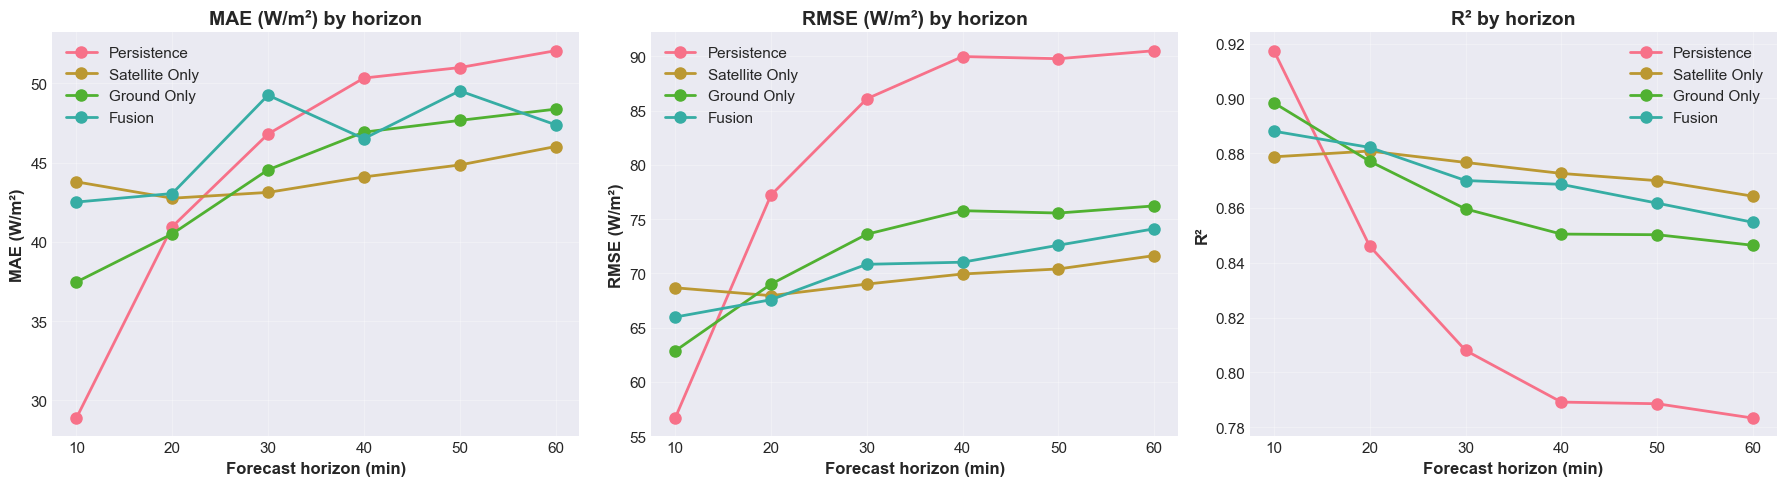

In [98]:
# Compute metrics by horizon for each model
horizon_metrics = []

for model_name, df in models.items():
    for horizon in sorted(df["horizon_min"].unique()):
        df_h = df[df["horizon_min"] == horizon]
        metrics = compute_metrics(df_h)
        horizon_metrics.append({
            "Model": model_name,
            "Horizon (min)": horizon,
            **metrics
        })

df_horizon = pd.DataFrame(horizon_metrics)

# Plot MAE and RMSE by horizon
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ["MAE (W/m²)", "RMSE (W/m²)", "R²"]
for ax, metric in zip(axes, metrics_to_plot):
    for model_name in models.keys():
        df_model = df_horizon[df_horizon["Model"] == model_name]
        ax.plot(
            df_model["Horizon (min)"],
            df_model[metric],
            marker='o',
            linewidth=2,
            markersize=8,
            label=model_name.replace("_", " ").title()
        )
    
    ax.set_xlabel("Forecast horizon (min)", fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f"{metric} by horizon", fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PRED_DIR / "metrics_by_horizon.png", dpi=150, bbox_inches='tight')
plt.show()


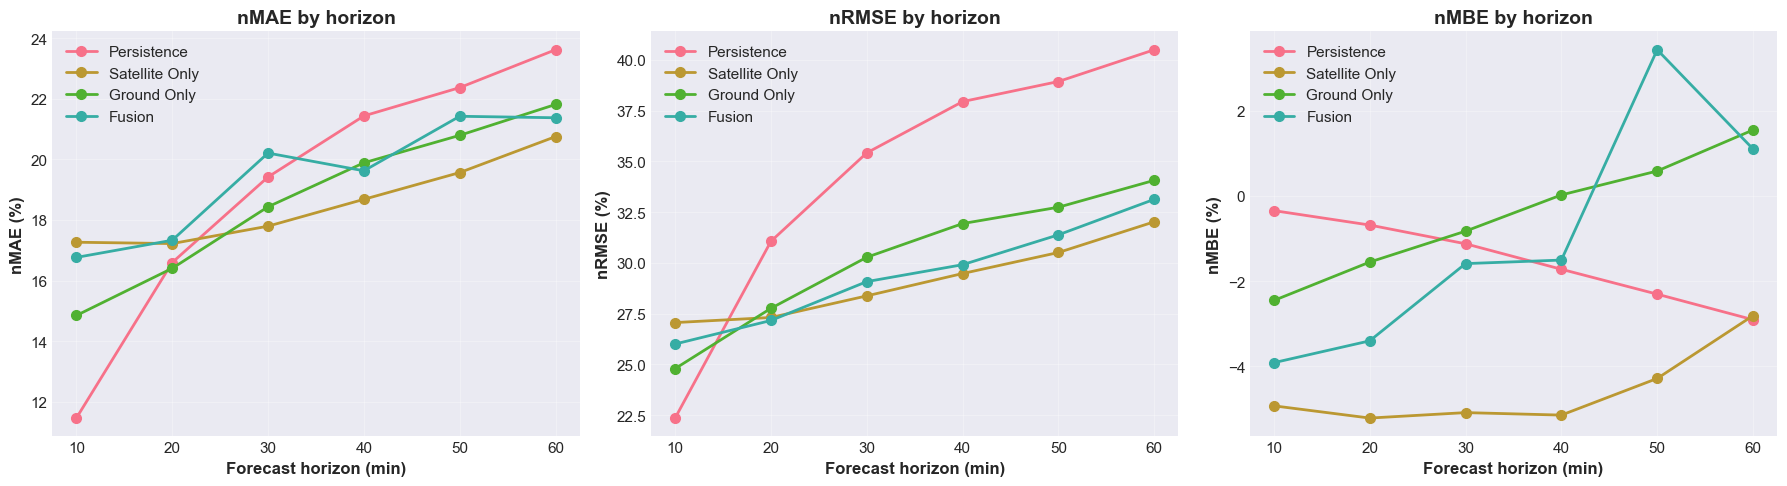

In [99]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def compute_normalized_metrics(
    df,
    target_col="y_true_ghi",
    pred_col="y_pred_ghi",
    eps=1e-6,
):
    y_true = df[target_col].values
    y_pred = df[pred_col].values

    # Remove NaN
    mask = ~(np.isnan(y_true) | np.isnan(y_pred))
    y_true = y_true[mask]
    y_pred = y_pred[mask]

    # Optional: remove night values (recommended)
    mask_day = y_true > 10.0
    y_true = y_true[mask_day]
    y_pred = y_pred[mask_day]

    if len(y_true) == 0:
        return {
            "nMAE": np.nan,
            "nRMSE": np.nan,
            "nMBE": np.nan,
            "N samples": 0,
        }

    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mbe = np.mean(y_pred - y_true)

    mean_obs = np.mean(y_true) + eps

    return {
        "nMAE": mae / mean_obs,
        "nRMSE": rmse / mean_obs,
        "nMBE": mbe / mean_obs,
        "N samples": len(y_true),
    }

horizon_metrics = []

for model_name, df in models.items():
    for horizon in sorted(df["horizon_min"].unique()):
        df_h = df[df["horizon_min"] == horizon]

        metrics = compute_normalized_metrics(df_h)

        horizon_metrics.append({
            "Model": model_name,
            "Horizon (min)": horizon,
            **metrics,
        })

df_horizon = pd.DataFrame(horizon_metrics)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ["nMAE", "nRMSE", "nMBE"]

for ax, metric in zip(axes, metrics_to_plot):
    for model_name in models.keys():
        df_model = df_horizon[df_horizon["Model"] == model_name]

        ax.plot(
            df_model["Horizon (min)"],
            100 * df_model[metric],  # convert to %
            marker="o",
            linewidth=2,
            markersize=7,
            label=model_name.replace("_", " ").title(),
        )

    ax.set_xlabel("Forecast horizon (min)", fontsize=12, fontweight="bold")
    ax.set_ylabel(f"{metric} (%)", fontsize=12, fontweight="bold")
    ax.set_title(f"{metric} by horizon", fontsize=14, fontweight="bold")
    ax.grid(True, alpha=0.3)
    ax.legend()

plt.tight_layout()
plt.savefig(PRED_DIR / "normalized_metrics_by_horizon.png", dpi=150, bbox_inches="tight")
plt.show()


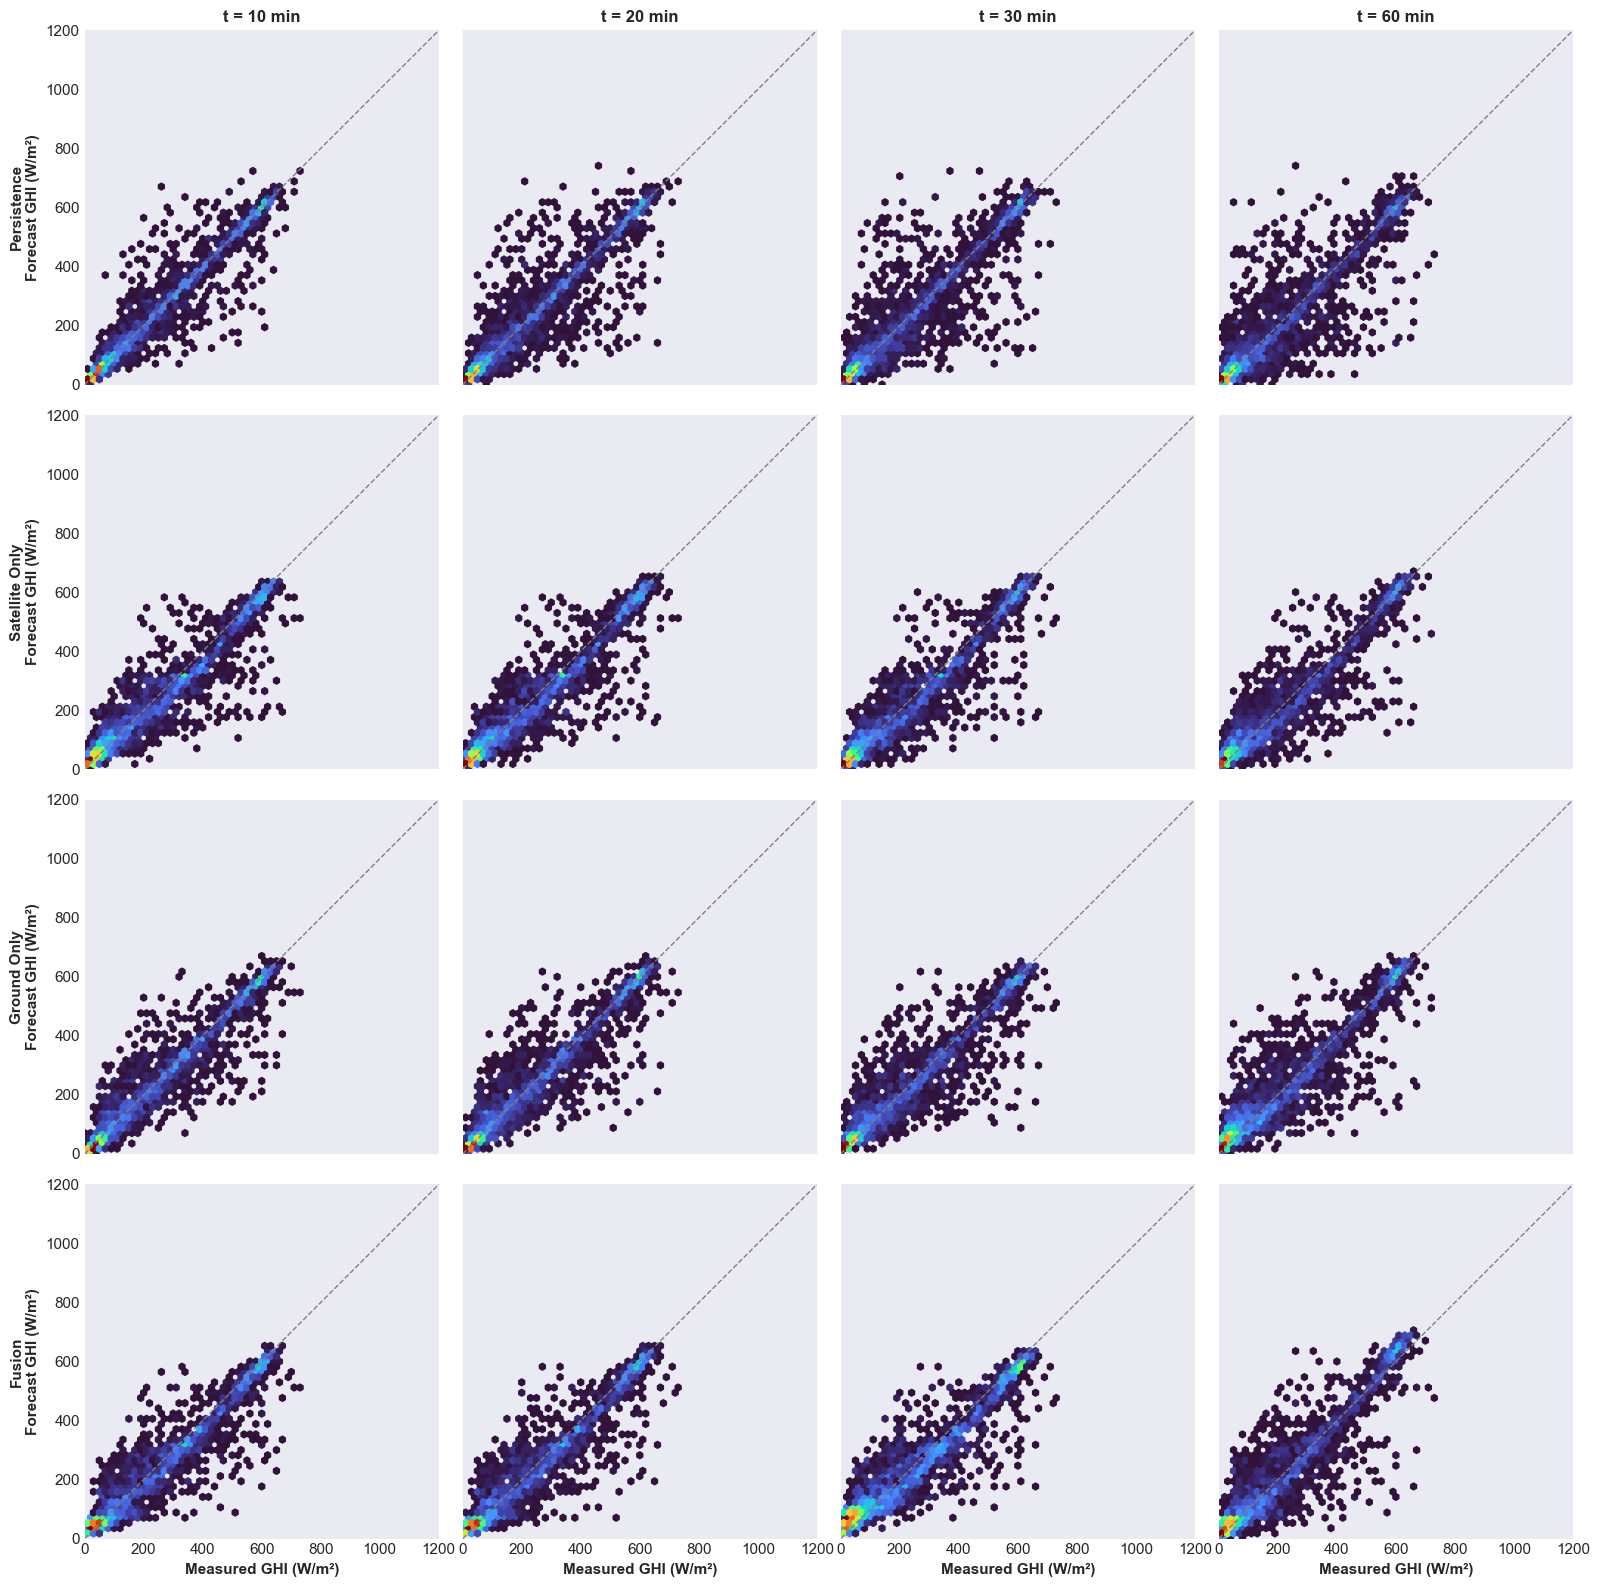

In [100]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def joint_density_plot(
    df,
    ax,
    horizon,
    vmax=1200,
    bins=40,
):
    df_h = df[df["horizon_min"] == horizon]

    x = df_h["y_true_ghi"].values
    y = df_h["y_pred_ghi"].values

    # density scatter
    hb = ax.hexbin(
        x, y,
        gridsize=60,
        extent=[0, vmax, 0, vmax],
        cmap="turbo",
        mincnt=1,
    )

    # 1:1 line
    ax.plot([0, vmax], [0, vmax], "--", color="gray", linewidth=1)

    ax.set_xlim(0, vmax)
    ax.set_ylim(0, vmax)
    ax.set_aspect("equal", adjustable="box")
    ax.grid(False)

    return hb

HORIZONS = [10, 20, 30, 60]  # minutes (adjust to your cfg)
MODEL_ORDER = ["persistence", "satellite_only", "ground_only", "fusion"]

fig, axes = plt.subplots(
    nrows=len(MODEL_ORDER),
    ncols=len(HORIZONS),
    figsize=(4 * len(HORIZONS), 4 * len(MODEL_ORDER)),
    sharex=True,
    sharey=True,
)

for i, model_name in enumerate(MODEL_ORDER):
    df_model = models[model_name]

    for j, h in enumerate(HORIZONS):
        ax = axes[i, j]
        joint_density_plot(df_model, ax, h)

        if i == 0:
            ax.set_title(f"t = {h} min", fontsize=12, fontweight="bold")

        if j == 0:
            ax.set_ylabel(
                f"{model_name.replace('_', ' ').title()}\nForecast GHI (W/m²)",
                fontsize=11,
                fontweight="bold",
            )

        if i == len(MODEL_ORDER) - 1:
            ax.set_xlabel("Measured GHI (W/m²)", fontsize=11, fontweight="bold")

plt.tight_layout()
plt.savefig(PRED_DIR / "joint_density_by_model_horizon.png", dpi=300)
plt.show()




In [104]:
df[["y_true_ghi", "y_pred_ghi"]].describe()


,y_true_ghi,y_pred_ghi
count,14778.000000,14778.000000
mean,236.818514,234.774954
std,196.336856,184.846495
min,1.000000,3.688905
25%,59.000004,74.612494
50%,184.000000,181.386620
75%,380.000030,343.962070
max,727.000000,697.138400


In [107]:
# Filter November predictions
df_nov = {}

# for model_name, df in models.items():
#     df_nov[model_name] = df[
#         (df["timestamp"].dt.month == 11)
#     ].copy()
#     print(f"{model_name}: {len(df_nov[model_name])} November points")

for model_name, df in models.items():
    df_nov[model_name] = df.copy()
    print(f"{model_name}: {len(df_nov[model_name])} November points")

import plotly.graph_objects as go
print(df["horizon_min"].unique())
HORIZON = 30 

fig = go.Figure()

# Plot ground truth (once)
ref_df = next(iter(df_nov.values()))
ref_h = ref_df[ref_df["horizon_min"] == HORIZON]

# Keep only one true value per timestamp
ref_true = (
    ref_h
    .drop_duplicates(subset="timestamp")
    .sort_values("timestamp")
)

fig.add_trace(
    go.Scatter(
        x=ref_true["timestamp"],
        y=ref_true["y_true_ghi"],
        mode="lines",
        name="True GHI",
        line=dict(color="black", width=3),
    )
)


# Plot each model
for model_name, df in df_nov.items():
    df_h = df[df["horizon_min"] == HORIZON]

    fig.add_trace(
        go.Scatter(
            x=df_h["timestamp"],
            y=df_h["y_pred_ghi"],
            mode="lines",
            name=model_name.replace("_", " ").title(),
            opacity=0.85,
        )
    )

fig.update_layout(
    title=f"GHI Predictions – November – Horizon {HORIZON} min",
    xaxis_title="Time",
    yaxis_title="GHI (W/m²)",
    legend_title="Model",
    template="plotly_white",
    height=500,
)

fig.show()


persistence: 14778 November points
satellite_only: 14778 November points
ground_only: 14778 November points
fusion: 14778 November points
[10 20 30 40 50 60]


# test

## 🎯 3. Scatter Plots: Predicted vs True

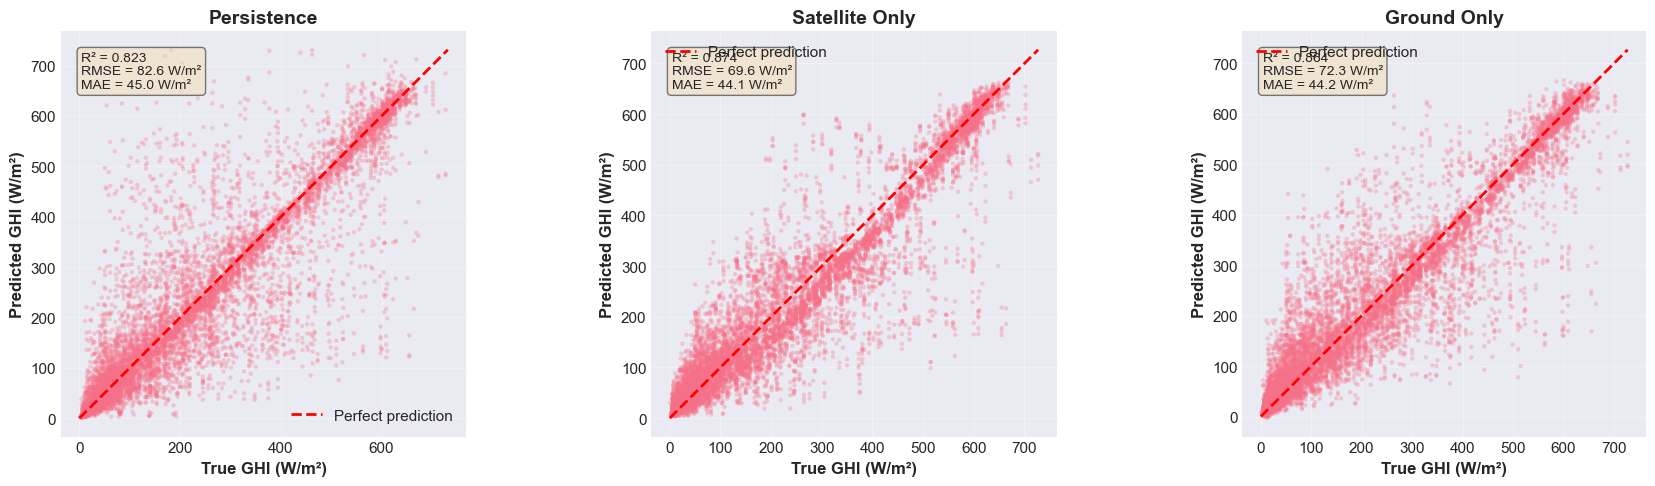

✅ Saved: scatter_pred_vs_true.png


In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, (model_name, df) in zip(axes, models.items()):
    # Sample points for faster plotting (if dataset is huge)
    if len(df) > 10000:
        df_sample = df.sample(n=10000, random_state=42)
    else:
        df_sample = df
    
    # Scatter plot
    ax.scatter(
        df_sample["y_true_ghi"],
        df_sample["y_pred_ghi"],
        alpha=0.3,
        s=10,
        edgecolors='none'
    )
    
    # Perfect prediction line
    max_val = max(df_sample["y_true_ghi"].max(), df_sample["y_pred_ghi"].max())
    ax.plot([0, max_val], [0, max_val], 'r--', linewidth=2, label='Perfect prediction')
    
    # Metrics on plot
    metrics = compute_metrics(df)
    text = f"R² = {metrics['R²']:.3f}\nRMSE = {metrics['RMSE (W/m²)']:.1f} W/m²\nMAE = {metrics['MAE (W/m²)']:.1f} W/m²"
    ax.text(
        0.05, 0.95, text,
        transform=ax.transAxes,
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    )
    
    ax.set_xlabel("True GHI (W/m²)", fontsize=12, fontweight='bold')
    ax.set_ylabel("Predicted GHI (W/m²)", fontsize=12, fontweight='bold')
    ax.set_title(model_name.replace("_", " ").title(), fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.savefig(PRED_DIR / "scatter_pred_vs_true.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: scatter_pred_vs_true.png")

## 📉 4. Residual Analysis

IndexError: index 3 is out of bounds for axis 1 with size 3

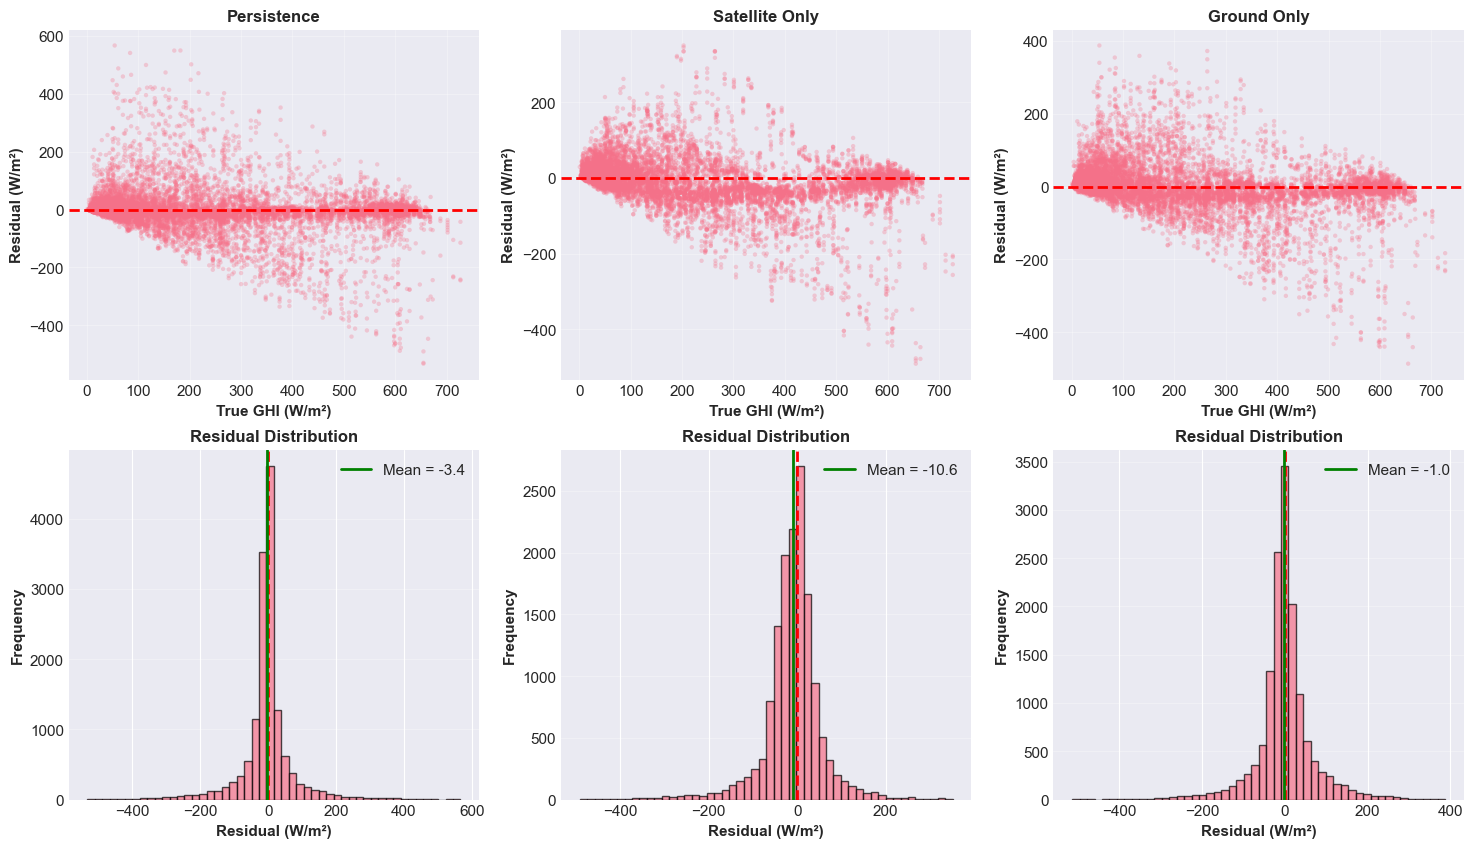

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for col, (model_name, df) in enumerate(models.items()):
    # Compute residuals
    residuals = df["y_pred_ghi"] - df["y_true_ghi"]
    
    # Row 1: Residuals vs True values
    ax1 = axes[0, col]
    if len(df) > 10000:
        df_sample = df.sample(n=10000, random_state=42)
        res_sample = residuals.loc[df_sample.index]
    else:
        df_sample = df
        res_sample = residuals
    
    ax1.scatter(df_sample["y_true_ghi"], res_sample, alpha=0.3, s=10, edgecolors='none')
    ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
    ax1.set_xlabel("True GHI (W/m²)", fontsize=11, fontweight='bold')
    ax1.set_ylabel("Residual (W/m²)", fontsize=11, fontweight='bold')
    ax1.set_title(f"{model_name.replace('_', ' ').title()}", fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Row 2: Residual histogram
    ax2 = axes[1, col]
    ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7)
    ax2.axvline(x=0, color='r', linestyle='--', linewidth=2)
    ax2.axvline(x=residuals.mean(), color='g', linestyle='-', linewidth=2, label=f'Mean = {residuals.mean():.1f}')
    ax2.set_xlabel("Residual (W/m²)", fontsize=11, fontweight='bold')
    ax2.set_ylabel("Frequency", fontsize=11, fontweight='bold')
    ax2.set_title("Residual Distribution", fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(PRED_DIR / "residual_analysis.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: residual_analysis.png")

## 🕐 5. Time Series Examples

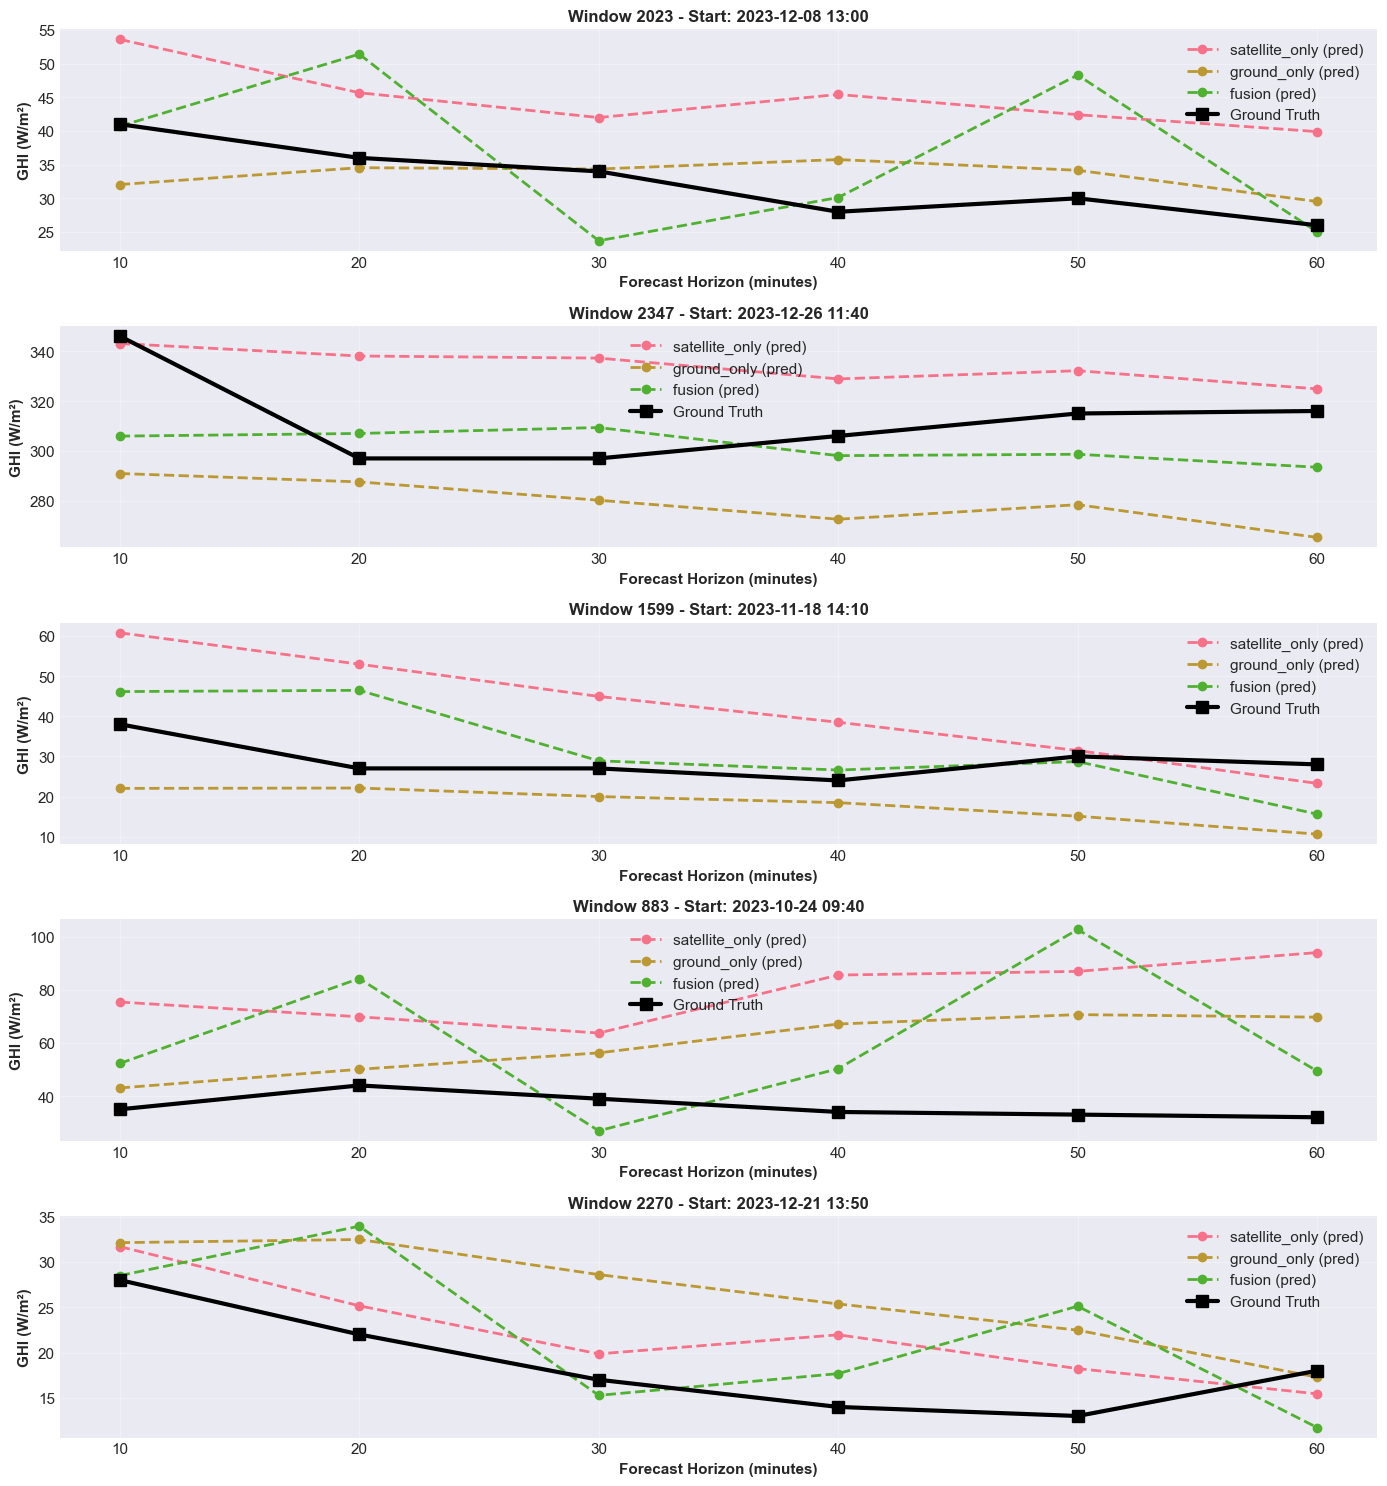

✅ Saved: time_series_examples.png


In [ ]:
# Select 5 random windows
np.random.seed(42)
sample_windows = np.random.choice(
    models["fusion"]["window_id"].unique(),
    size=min(5, len(models["fusion"]["window_id"].unique())),
    replace=False
)

fig, axes = plt.subplots(5, 1, figsize=(14, 15))

for i, (ax, window_id) in enumerate(zip(axes, sample_windows)):
    for model_name, df in models.items():
        df_window = df[df["window_id"] == window_id].sort_values("horizon_min")
        
        if len(df_window) == 0:
            continue
        
        # Plot predictions
        ax.plot(
            df_window["horizon_min"],
            df_window["y_pred_ghi"],
            marker='o',
            linewidth=2,
            markersize=6,
            label=f"{model_name} (pred)",
            linestyle='--'
        )
    
    # Plot ground truth (only once)
    df_window = models["fusion"][models["fusion"]["window_id"] == window_id].sort_values("horizon_min")
    ax.plot(
        df_window["horizon_min"],
        df_window["y_true_ghi"],
        marker='s',
        linewidth=3,
        markersize=8,
        label="Ground Truth",
        color='black',
        linestyle='-'
    )
    
    ax.set_xlabel("Forecast Horizon (minutes)", fontsize=11, fontweight='bold')
    ax.set_ylabel("GHI (W/m²)", fontsize=11, fontweight='bold')
    ax.set_title(
        f"Window {window_id} - Start: {df_window.iloc[0]['timestamp'].strftime('%Y-%m-%d %H:%M')}",
        fontsize=12,
        fontweight='bold'
    )
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PRED_DIR / "time_series_examples.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: time_series_examples.png")

## 📅 6. Performance by Time of Day

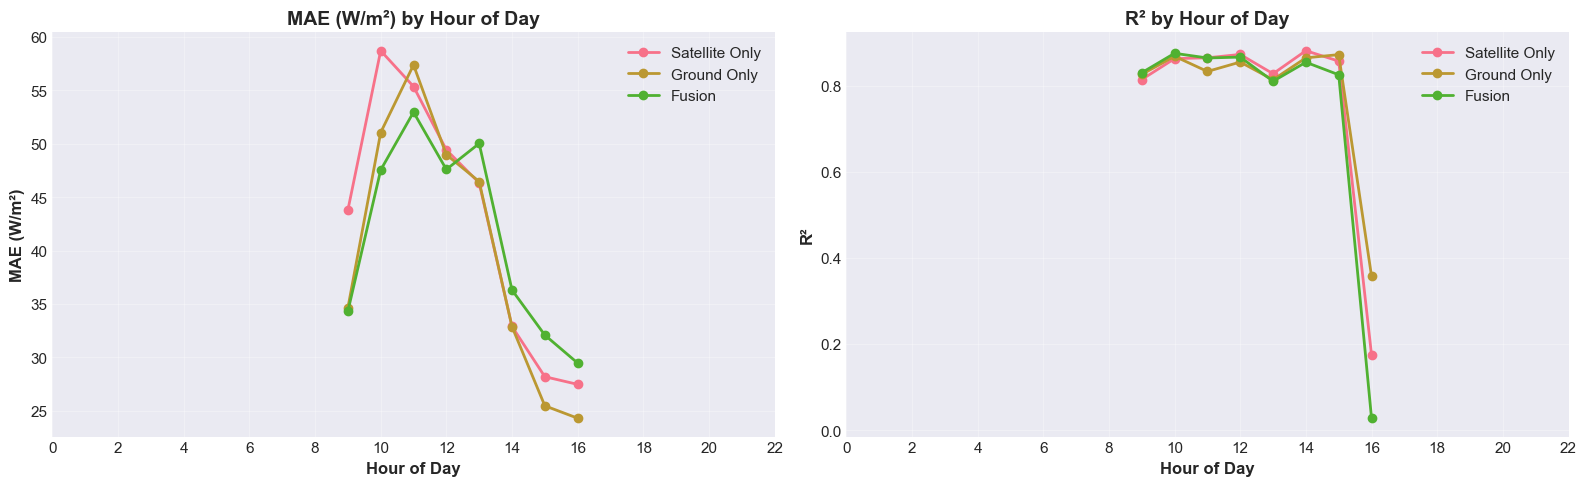

✅ Saved: performance_by_hour.png


In [ ]:
# Add hour of day
for model_name, df in models.items():
    df["hour"] = df["timestamp"].dt.hour

# Compute metrics by hour
hour_metrics = []
for model_name, df in models.items():
    for hour in range(24):
        df_h = df[df["hour"] == hour]
        if len(df_h) > 10:  # Only if enough samples
            metrics = compute_metrics(df_h)
            hour_metrics.append({
                "Model": model_name,
                "Hour": hour,
                **metrics
            })

df_hour = pd.DataFrame(hour_metrics)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, metric in zip(axes, ["MAE (W/m²)", "R²"]):
    for model_name in models.keys():
        df_model = df_hour[df_hour["Model"] == model_name]
        ax.plot(
            df_model["Hour"],
            df_model[metric],
            marker='o',
            linewidth=2,
            markersize=6,
            label=model_name.replace("_", " ").title()
        )
    
    ax.set_xlabel("Hour of Day", fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f"{metric} by Hour of Day", fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, 24, 2))

plt.tight_layout()
plt.savefig(PRED_DIR / "performance_by_hour.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: performance_by_hour.png")

## ☁️ 7. Performance by Sky Conditions (CSI bins)

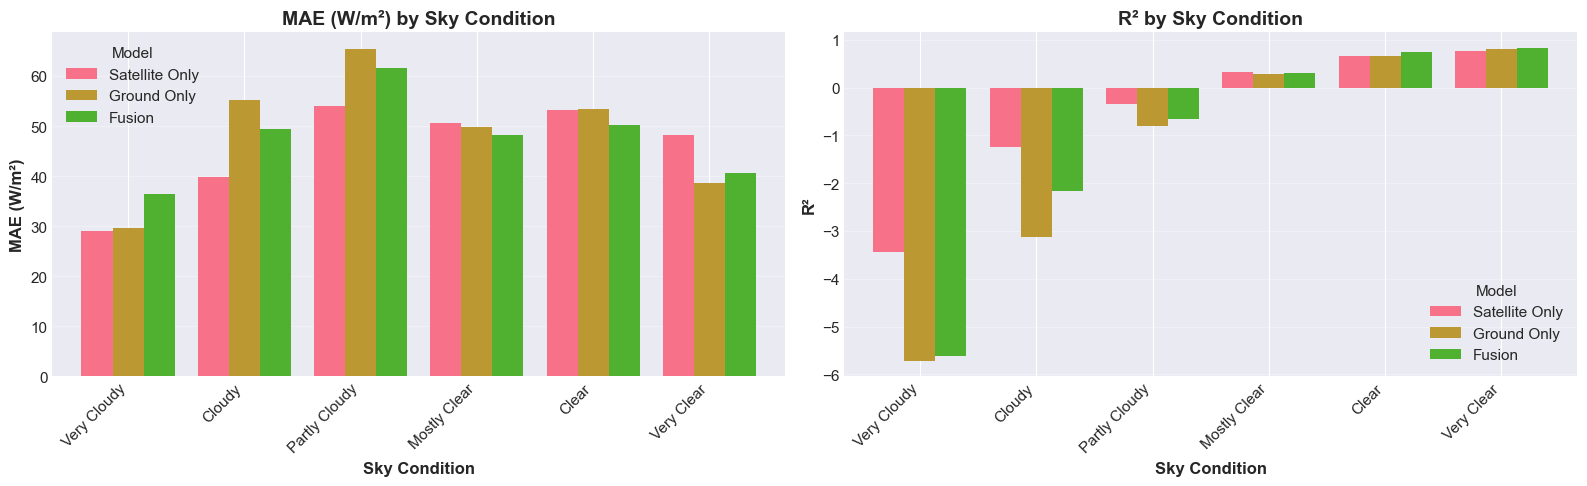

✅ Saved: performance_by_sky_condition.png


In [ ]:
# Bin CSI values (clear sky index)
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.5]
labels = ["Very Cloudy", "Cloudy", "Partly Cloudy", "Mostly Clear", "Clear", "Very Clear"]

for model_name, df in models.items():
    df["sky_condition"] = pd.cut(df["y_true_csi"], bins=bins, labels=labels)

# Compute metrics by sky condition
sky_metrics = []
for model_name, df in models.items():
    for condition in labels:
        df_cond = df[df["sky_condition"] == condition]
        if len(df_cond) > 10:
            metrics = compute_metrics(df_cond)
            sky_metrics.append({
                "Model": model_name,
                "Condition": condition,
                **metrics
            })

df_sky = pd.DataFrame(sky_metrics)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for ax, metric in zip(axes, ["MAE (W/m²)", "R²"]):
    df_pivot = df_sky.pivot(index="Condition", columns="Model", values=metric)
    df_pivot = df_pivot.reindex(labels)  # Preserve order
    
    df_pivot.plot(kind='bar', ax=ax, width=0.8)
    ax.set_xlabel("Sky Condition", fontsize=12, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f"{metric} by Sky Condition", fontsize=14, fontweight='bold')
    ax.legend(title="Model", labels=[m.replace("_", " ").title() for m in models.keys()])
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.savefig(PRED_DIR / "performance_by_sky_condition.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: performance_by_sky_condition.png")

## 📊 8. Error Distribution Comparison

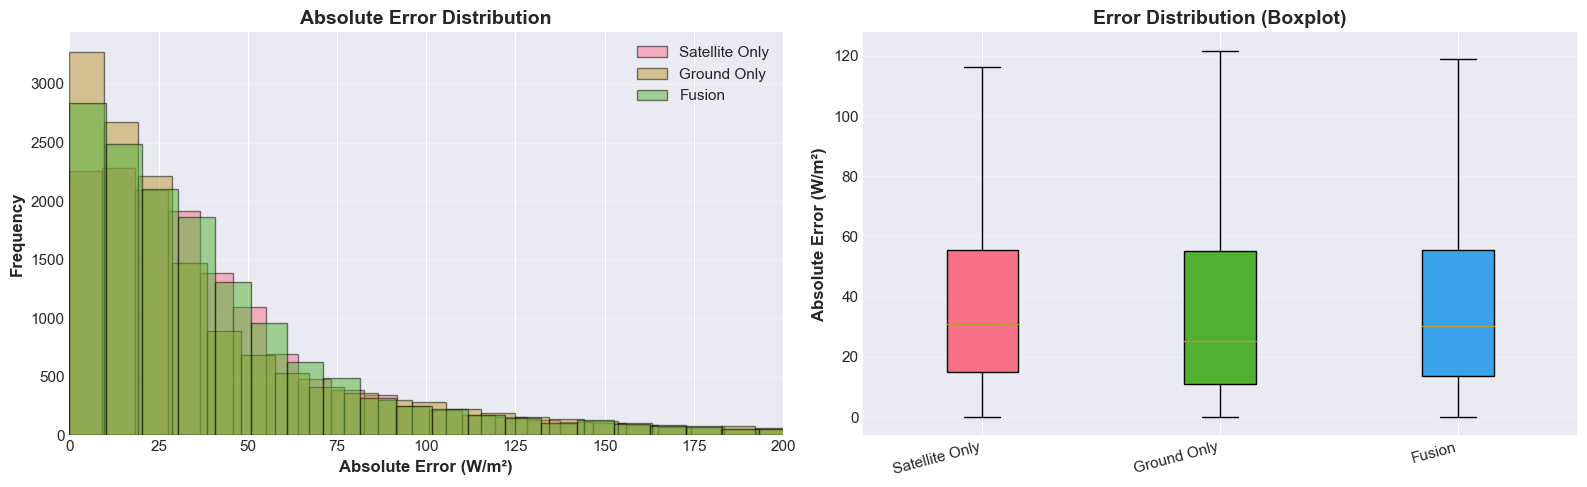

✅ Saved: error_distribution.png


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Absolute errors
ax1 = axes[0]
for model_name, df in models.items():
    abs_errors = np.abs(df["y_pred_ghi"] - df["y_true_ghi"])
    ax1.hist(
        abs_errors,
        bins=50,
        alpha=0.5,
        label=model_name.replace("_", " ").title(),
        edgecolor='black'
    )

ax1.set_xlabel("Absolute Error (W/m²)", fontsize=12, fontweight='bold')
ax1.set_ylabel("Frequency", fontsize=12, fontweight='bold')
ax1.set_title("Absolute Error Distribution", fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xlim(0, 200)  # Focus on reasonable errors

# Boxplot comparison
ax2 = axes[1]
error_data = []
labels_box = []
for model_name, df in models.items():
    abs_errors = np.abs(df["y_pred_ghi"] - df["y_true_ghi"])
    error_data.append(abs_errors)
    labels_box.append(model_name.replace("_", " ").title())

bp = ax2.boxplot(error_data, labels=labels_box, patch_artist=True, showfliers=False)
for patch, color in zip(bp['boxes'], sns.color_palette("husl", len(models))):
    patch.set_facecolor(color)

ax2.set_ylabel("Absolute Error (W/m²)", fontsize=12, fontweight='bold')
ax2.set_title("Error Distribution (Boxplot)", fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(labels_box, rotation=15, ha='right')

plt.tight_layout()
plt.savefig(PRED_DIR / "error_distribution.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: error_distribution.png")

## 🎯 9. Model Comparison Summary

In [ ]:
# Create comprehensive comparison table
comparison = []

for model_name, df in models.items():
    metrics = compute_metrics(df)
    
    # Additional metrics
    abs_errors = np.abs(df["y_pred_ghi"] - df["y_true_ghi"])
    
    comparison.append({
        "Model": model_name.replace("_", " ").title(),
        "MAE (W/m²)": f"{metrics['MAE (W/m²)']:.2f}",
        "RMSE (W/m²)": f"{metrics['RMSE (W/m²)']:.2f}",
        "R²": f"{metrics['R²']:.4f}",
        "MAPE (%)": f"{metrics['MAPE (%)']:.2f}",
        "Median Error (W/m²)": f"{abs_errors.median():.2f}",
        "90th Percentile Error (W/m²)": f"{abs_errors.quantile(0.9):.2f}",
        "Max Error (W/m²)": f"{abs_errors.max():.2f}",
    })

df_comparison = pd.DataFrame(comparison)

print("\n" + "="*100)
print("📊 COMPREHENSIVE MODEL COMPARISON")
print("="*100)
print(df_comparison.to_string(index=False))
print("="*100)

# Save to CSV
df_comparison.to_csv(PRED_DIR / "model_comparison.csv", index=False)
print("\n✅ Saved: model_comparison.csv")


📊 COMPREHENSIVE MODEL COMPARISON
         Model MAE (W/m²) RMSE (W/m²)     R² MAPE (%) Median Error (W/m²) 90th Percentile Error (W/m²) Max Error (W/m²)
Satellite Only      46.22       68.79 0.8772    53.39               30.85                       104.92           458.44
   Ground Only      45.51       72.78 0.8626    45.73               25.31                       114.55           480.25
        Fusion      45.87       70.41 0.8714    46.33               30.27                       103.81           508.27

✅ Saved: model_comparison.csv


## 📈 10. Best vs Worst Predictions

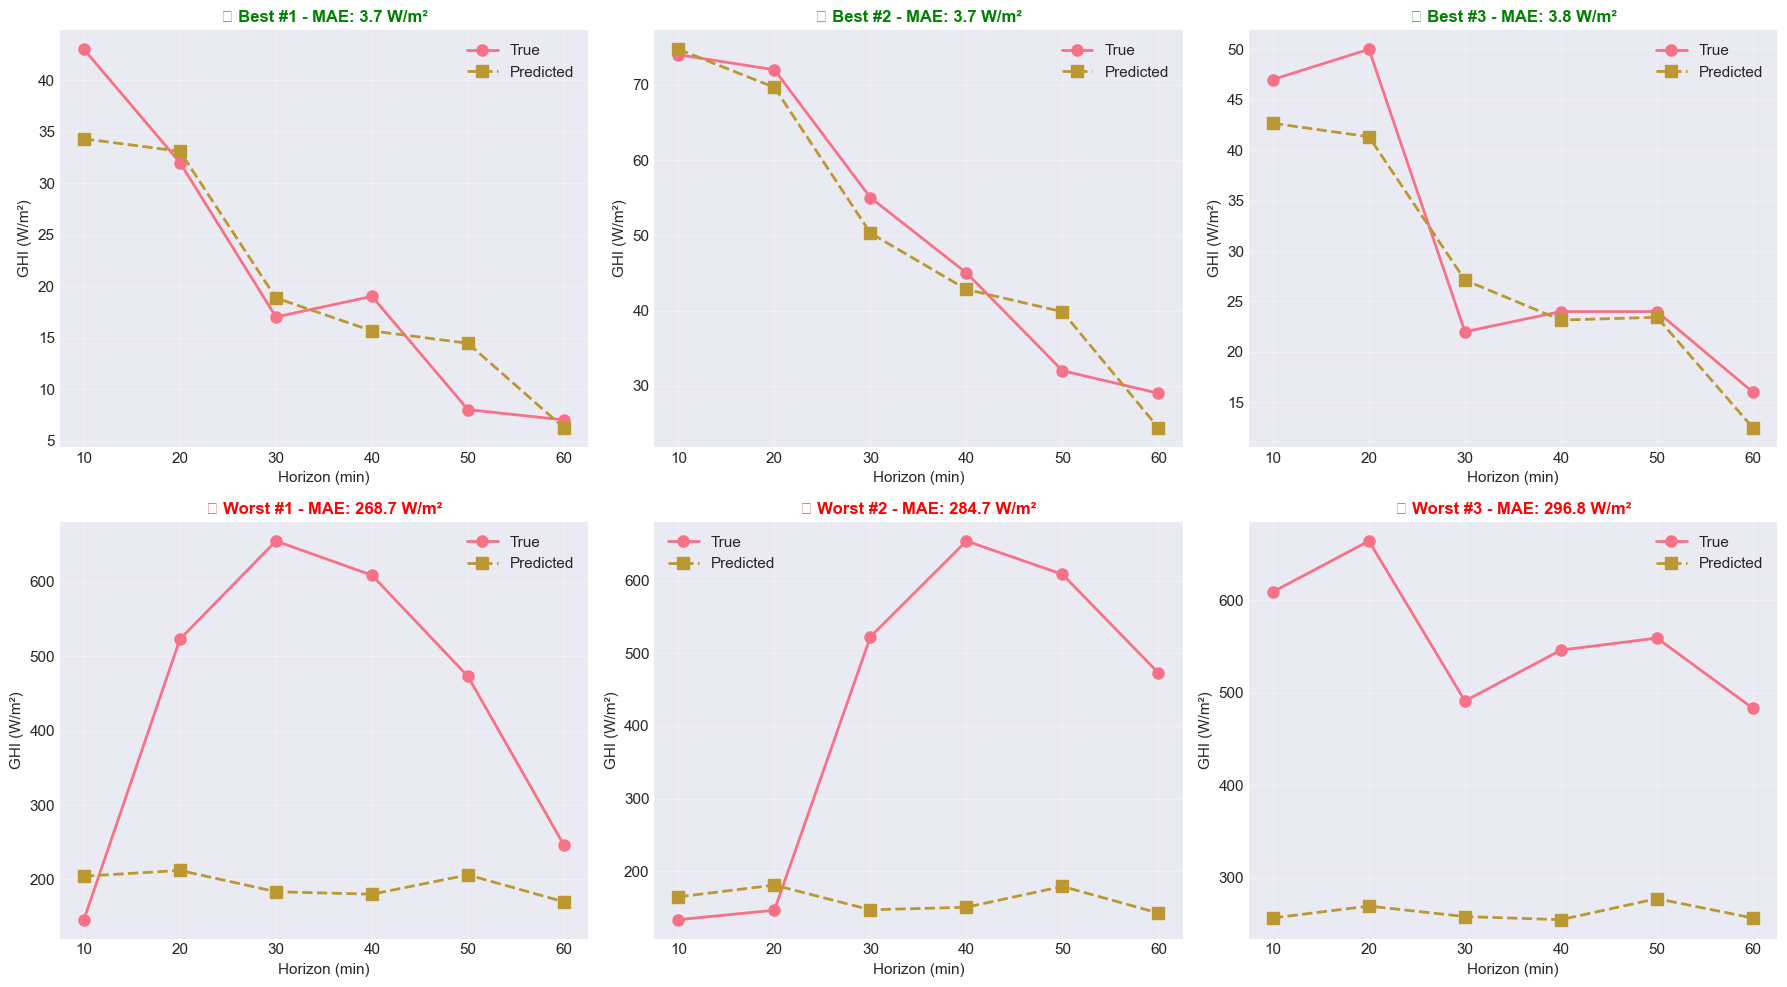

✅ Saved: best_worst_predictions.png


In [ ]:
# Find best and worst windows for fusion model
df_fusion = models["fusion"].copy()

# Compute window-level MAE
window_mae = df_fusion.groupby("window_id").apply(
    lambda x: mean_absolute_error(x["y_true_ghi"], x["y_pred_ghi"])
).sort_values()

best_windows = window_mae.head(3).index.tolist()
worst_windows = window_mae.tail(3).index.tolist()

# Plot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, window_id in enumerate(best_windows):
    ax = axes[0, i]
    df_w = df_fusion[df_fusion["window_id"] == window_id].sort_values("horizon_min")
    
    ax.plot(df_w["horizon_min"], df_w["y_true_ghi"], 'o-', linewidth=2, markersize=8, label="True")
    ax.plot(df_w["horizon_min"], df_w["y_pred_ghi"], 's--', linewidth=2, markersize=8, label="Predicted")
    
    mae = mean_absolute_error(df_w["y_true_ghi"], df_w["y_pred_ghi"])
    ax.set_title(f"✅ Best #{i+1} - MAE: {mae:.1f} W/m²", fontsize=12, fontweight='bold', color='green')
    ax.set_xlabel("Horizon (min)")
    ax.set_ylabel("GHI (W/m²)")
    ax.legend()
    ax.grid(True, alpha=0.3)

for i, window_id in enumerate(worst_windows):
    ax = axes[1, i]
    df_w = df_fusion[df_fusion["window_id"] == window_id].sort_values("horizon_min")
    
    ax.plot(df_w["horizon_min"], df_w["y_true_ghi"], 'o-', linewidth=2, markersize=8, label="True")
    ax.plot(df_w["horizon_min"], df_w["y_pred_ghi"], 's--', linewidth=2, markersize=8, label="Predicted")
    
    mae = mean_absolute_error(df_w["y_true_ghi"], df_w["y_pred_ghi"])
    ax.set_title(f"❌ Worst #{i+1} - MAE: {mae:.1f} W/m²", fontsize=12, fontweight='bold', color='red')
    ax.set_xlabel("Horizon (min)")
    ax.set_ylabel("GHI (W/m²)")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(PRED_DIR / "best_worst_predictions.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved: best_worst_predictions.png")

## 🎊 Summary

### Generated Outputs:

**CSV Files:**
- `model_comparison.csv` - Comprehensive metrics table

**Visualizations:**
1. `metrics_by_horizon.png` - MAE, RMSE, R² by forecast horizon
2. `scatter_pred_vs_true.png` - Scatter plots for all models
3. `residual_analysis.png` - Residual plots and distributions
4. `time_series_examples.png` - 5 example prediction windows
5. `performance_by_hour.png` - Performance by time of day
6. `performance_by_sky_condition.png` - Performance by cloudiness
7. `error_distribution.png` - Error histograms and boxplots
8. `best_worst_predictions.png` - Best and worst prediction examples

---

### Next Steps:
1. Analyze which conditions cause large errors
2. Consider ensemble methods if models have complementary strengths
3. Investigate temporal patterns in errors
4. Test on different seasons or weather conditions

🎉 **Analysis Complete!**